## cats and dogs 이진 분류

### 이진분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기


#### Kaggle 데이터 다운로드
- Kaggle
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼
   
1. Kaggle 계정 만들기
2. 설정진입
    - https://www.kaggle.com/settings
    - api > create new token >kaggle.json 다운로드
3. 파이썬 kaggle 패키지 설치
    - !pip install kaggle
4. kaggle.json 파일 위치
    - 리눅스/유닉스 :  ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle
        - C:\Users\Admin에 .kaggle 폴더 만들기
    - 다운로드 받은 kaggle.json 파일 위치에 복사붙여넣기

5. https://www.kaggle.com/competitions/dogs-vs-cats/data
    - join the competition 누르기
    - !kaggle competitions download -c dogs-vs-cats

In [2]:
!pip install kaggle


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# 데이터셋 다운로드
!kaggle competitions download -c dogs-vs-cats

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/dogs-vs-cats


- 다운로드받은 파일 폴더 정리 (data - train , test)
- data를 gitignore에 넣어 깃허브에 gitignore파일 올리기


##### 데이터셋 전처리

In [4]:
# 파이썬 모듈 로드
import os, shutil, random

In [5]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True)  
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])] 
    samples = random.sample(all_files, num_samples)
    for f in samples :
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir,f))


 - sample_data(base_dir, './data/sample/cat', 500)
    - os.makedirs(dst_dir, exist_ok=True) :./data/sample/cat 폴더가 없으면 생성, exist_ok=True는 이미 존재하면 다시 만들지 않음
    - all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]  : ./data/sample/cat  파일경로의 마지막인 cat으로 시작하는 파일명을 가진 것만 './data/train' 폴더에서 추출 =>즉 cat만 추출
    - samples = random.sample(all_files, num_samples) cat 12500개 중에서 랜덤으로 500개 뽑음
    - for f in samples : shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir,f))     : ./data/train  의 500개를       ./data/sample/cat로 복사함  


In [6]:
base_dir = './data/train'   #원본폴더 25000개


In [7]:
os.makedirs('./data/sample/cat', exist_ok=True)   
os.makedirs('./data/sample/dog', exist_ok=True)

In [8]:
#sample_data()함수 사용
sample_data(base_dir, './data/sample/cat', 500)
sample_data(base_dir, './data/sample/dog', 500)

<img src='./데이터준비(폴더경로).png' width = 700>

##### 파이토치 시작!
- ImageFolder 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat ->0 , dog ->1

In [9]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [10]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [11]:
from torch.utils.data import random_split

train_dataset = ImageFolder('./data/sample', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


##### train_loader 시각화

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [13]:
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf' # 나눔고딕코딩 사용, 나눔고딕에서 오류발생(!)
font = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름조회
rc('font', family=font) # 한글깨짐현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스 표시 깨짐 해결!

In [14]:
# 시본 형태로 차트 변경
sns.set_style('darkgrid')

# 시본 사용시 한글깨짐 해결
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus':False}) 

In [15]:
# 배치 하나 꺼내기
images , labels = next(iter(train_loader))

In [16]:
class_names =['cat','dog']

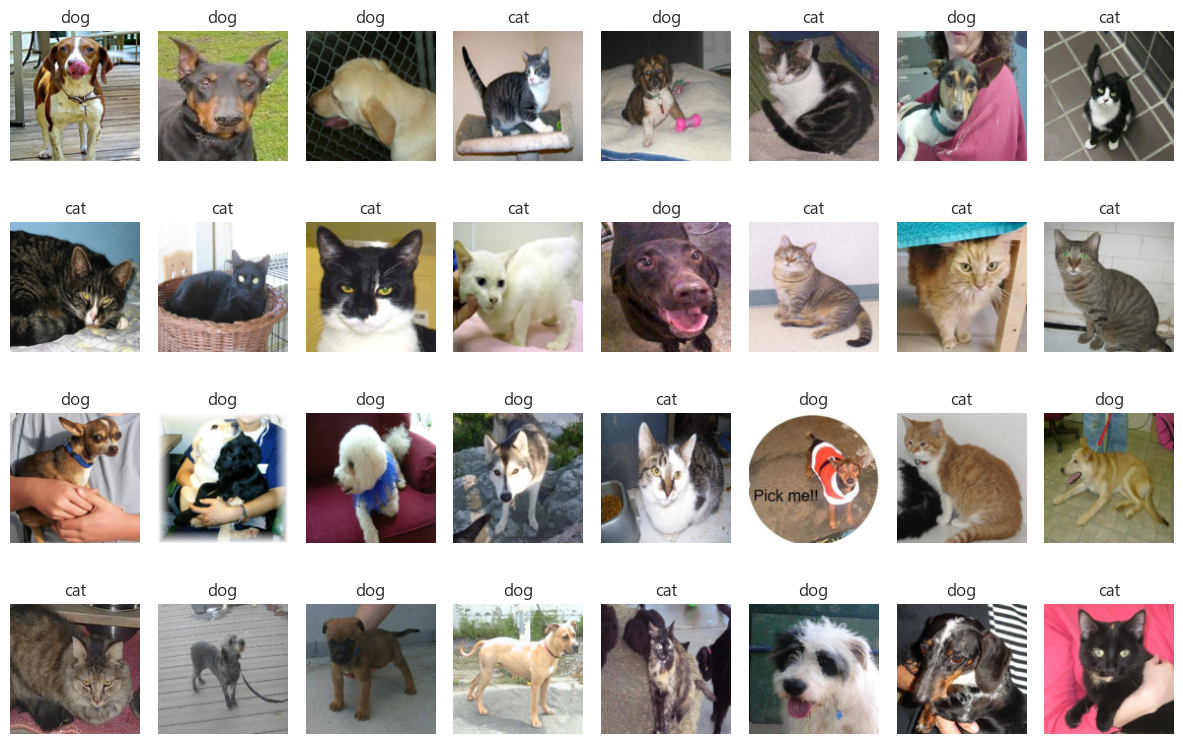

In [17]:
# 첫번째 배치 32개의 이미지 시각화

# [3, 128, 128] 형태의 텐서를 squeeze()로 변환할 수는 없어요.
#squeeze()는 차원의 크기가 1인 차원만 제거하기 때문에, squeeze()를 사용해도 차원 크기가 3인 채널 차원은 그대로 남게 됩니다. 즉, squeeze()는 1인 차원만 지우고, 3은 그대로 유지해요.

#images[i]의 shape이 (3, 128, 128)이라면, permute(1, 2, 0)을 사용해서 (128, 128, 3) 형태로 변경해야 합니다. 
#이렇게 하면 matplotlib에서 RGB 컬러 이미지로 제대로 시각화할 수 있어요.

plt.figure(figsize=(12,8))
for i in range(32) :            
    plt.subplot(4,8, i+1)
    img = images[i].permute(1,2,0)  # 컬러채널이기에 matplotlib 표현시 순서 변경
    plt.imshow( img)
    plt.axis('off')
    plt.title(f'{class_names[labels[i].item()]}')
plt.tight_layout()
plt.show()

##### CNN 모델

In [18]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super( CatDogCNN, self).__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(64*32*32,128)      #conv1, conv2 두번의 풀링을 거치면 128->64->32가 된다. / conv2의 outchannel은 64이다.
        self.fc2 = nn.Linear(128,1)             #마지막 분류가 0, 1

    def forward(self, x):
        x = self.pool( F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*32*32)  
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    



<img src = './시그모이드랑소프트맥스차이.png'>

In [20]:
# cuda 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [21]:
# 훈련 함수
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0 

    for images, labels in loader:
        images , labels = images.to(device), labels.float().to(device).unsqueeze(1)  # 1,0 ->[1,],[0,]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(loader)
        


- nn.BCELoss()는 Sigmoid 활성화 함수를 미리 적용한 모델의 출력을 기대합니다. 그래서 모델의 출력이 0과 1 사이의 확률로 변환되어야 합니다.
- .float()은 labels를 float 데이터 타입으로 변환합니다.
    - 보통 이진 분류에서는 레이블을 0 또는 1로 가지고 있지만, 손실 함수인 BCELoss(이진 교차 엔트로피 손실)에서는 레이블이 float형이어야 하기 때문에 float으로 변환하는 것입니다.
- .unsqueeze()는 텐서에 차원을 하나 추가하는 함수

In [22]:
# 훈련
EPOCH =10
for epoch in range(EPOCH):
    loss = train(model, train_loader, criterion, optimizer)
    print(f'{epoch+1} / {EPOCH}  Loss : {loss:.4f}')

1 / 10  Loss : 0.7214
2 / 10  Loss : 0.6522
3 / 10  Loss : 0.5952
4 / 10  Loss : 0.5479
5 / 10  Loss : 0.5124
6 / 10  Loss : 0.4550
7 / 10  Loss : 0.4175
8 / 10  Loss : 0.3448
9 / 10  Loss : 0.2869
10 / 10  Loss : 0.2124


##### 예측 시각화
- 훈련 데이터로 예측 결과를 확인

- outputs > 0.5 → 0.5보다 크면 dog(1), 작으면 cat(0)으로 판단.

- .int()로 정수형(0 또는 1)으로 변환.

- .cpu() → GPU 텐서를 CPU로 옮김.

- .squeeze() → 차원을 줄여줌 (불필요한 차원 제거).

- preds는 결국 0 또는 1로 이루어진 예측 결과 벡터입니다.

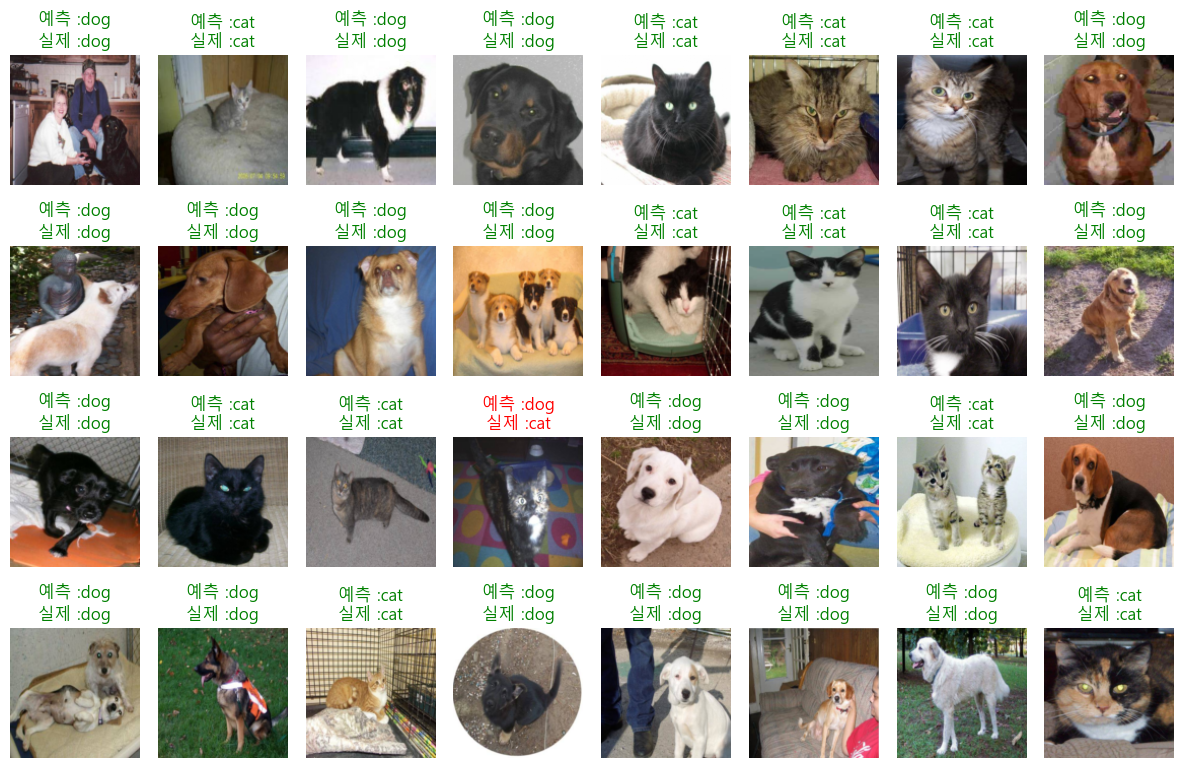

In [23]:
#검증
model.eval()
images, labels = next(iter(train_loader))
images  = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = (outputs >0.5).int().cpu().squeeze()  
plt.figure(figsize =(12,8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    pred_label = 'dog' if preds[i]==1 else 'cat'
    true_label = 'dog' if labels[i]==1 else 'cat'
    color = 'green' if pred_label== true_label else 'red'
    plt.title(f'예측 :{ pred_label}\n실제 :{true_label}' , color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

##### 모델저장/불러오기

In [24]:
# 가중치만 저장
torch.save(model.state_dict(), './catdog_weight.pth')

In [25]:
#모델 전체 저장
torch.save(model, './catdog_model.pth')

In [26]:
#가중치만 불러올 때 
model2 = CatDogCNN().to(device)
model2.load_state_dict(torch.load('./catdog_weight.pth', map_location=device))
model2

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

##### 전체 모델을 불러올 때
- cnn에 필요한 torch import문
- 클래스정의

In [27]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super( CatDogCNN, self).__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(64*32*32,128)      #conv1, conv2 두번의 풀링을 거치면 128->64->32가 된다. / conv2의 outchannel은 64이다.
        self.fc2 = nn.Linear(128,1)             #마지막 분류가 0, 1

    def forward(self, x):
        x = self.pool( F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*32*32)  
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    

In [29]:
model3 = torch.load('./catdog_model.pth', weights_only=False)
model3

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

#### 테스트 이미지로 테스트
- data/test에 있는 1.jpg ~12500.jpg까지 dog, cat 구분

In [30]:
# 사용모듈 로드
import torch
from torchvision import transforms
from PIL import Image

In [31]:
#transform 위 선언
img =Image.open('./data/test/200.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0)      # [3,128,128]->[1, 3, 128, 128] [batch_size, channels, height, width]


print(img_tensor)
img.show()

tensor([[[[0.0000, 0.0431, 0.0157,  ..., 0.0157, 0.0431, 0.0000],
          [0.0392, 0.5137, 0.6627,  ..., 0.6627, 0.5137, 0.0392],
          [0.0314, 0.7686, 0.9804,  ..., 0.9804, 0.7686, 0.0314],
          ...,
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118],
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118],
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118]],

         [[0.0000, 0.0431, 0.0157,  ..., 0.0157, 0.0431, 0.0000],
          [0.0392, 0.5137, 0.6627,  ..., 0.6627, 0.5137, 0.0392],
          [0.0314, 0.7686, 0.9804,  ..., 0.9804, 0.7686, 0.0314],
          ...,
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118],
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118],
          [0.0078, 0.8000, 0.9961,  ..., 0.9961, 0.8039, 0.0118]],

         [[0.0000, 0.0431, 0.0157,  ..., 0.0157, 0.0431, 0.0000],
          [0.0392, 0.5137, 0.6627,  ..., 0.6627, 0.5137, 0.0392],
          [0.0314, 0.7686, 0.9804,  ..., 0

In [32]:
model

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
model.eval()

with torch.no_grad():
    output = model(img_tensor.to(device))
    print("모델 출력값:", output.item())  # 예: 0.02, 0.7 등
    pred = (output >0.5 ).int().item()

'Dog' if pred == 1 else 'Cat'

모델 출력값: 0.20881451666355133


'Cat'

- 물론 개 이미지를 dog, 고양이 이미지를 cat으로 예측성공하느 경우도 있지만
- 테스트 데이터를 예측해보니 개 이미지를 cat이라고 예측하는 경우가 꽤 있다.

In [34]:
import os

# test_dir 경로가 이미지 파일들이 있는 디렉토리라고 가정
print("Current Working Directory:", os.getcwd())
test_dir = './data/test'

# test_dir에 있는 파일 목록을 가져오고, 이미지 파일만 필터링
image_files = [fname for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg'))]


Current Working Directory: c:\Source\iot_dataanalysis_2025\day52


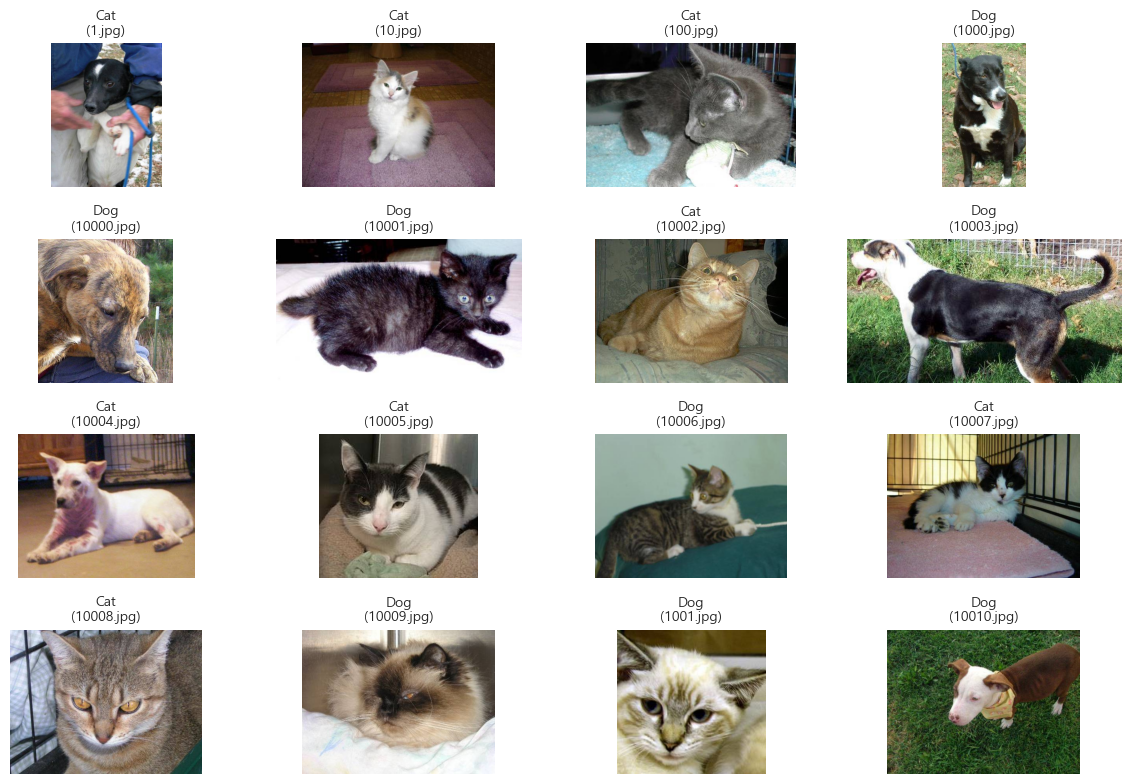

In [35]:
# 예측과 시각화 동시
plt.figure(figsize=(12,8))
for i, fname in enumerate(image_files[0:16]): 
    img_path = os.path.join(test_dir, fname)
    img=Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = 'Dog' if output.item() >0.5 else 'Cat'

    # 이미지 출력
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(f'{pred}\n({fname})', fontsize = 10)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### kaggle  competitions 도전
### 케글 순서
1. https://www.kaggle.com/competitions/dogs-vs-cats > Data > Join the competition 클릭
2. Code > New Notebook 클릭(colab과 동일) , 노트북명 작성 후 저장
3. 노트북 작성
4. 캐글 서버 내 압축파일 처리부분만 새로 코딩
5. 위의 소스 그대로 사용가능
6. submission.csv 만드는 코드 추가
7. submission.csv 제출
8. 캐글 토트북 settings > accelertor > GPU T4 x2 , GPU P1000으로 GUP 사용가능(1주 30시간 제한)